In [6]:
import sys
sys.path.append('./module')

In [8]:
from graph.graph import *
import networkx as nx
from itertools import combinations
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit import IBMQ

algorithm_globals.massive=True

import numpy as np
import pandas as pd
%matplotlib inline

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import IBMQ
with open('/Users/minhyeong-gyu/Desktop/code/local_api/ibmq_api.txt', 'r') as f:
    my_api_token = f.readline()

## 1. 어카운트 세팅

In [11]:
# IBMQ.save_account(my_api_token,overwrite=True)
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q-kqc',group='internal',project = 'default')

/var/folders/r7/4kckzfxd78df0ln3wt2tjs180000gn/T/ipykernel_36823/3751798911.py:2: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account() # Load account from disk
/var/folders/r7/4kckzfxd78df0ln3wt2tjs180000gn/T/ipykernel_36823/3751798911.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account() # Load account from disk


In [12]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token=my_api_token,overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

#### Runtime은 Runtime만의 Provider를 설정해줘야함. 

## 2. Primitive 비교

In [13]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import Estimator,Sampler
from qiskit import QuantumCircuit,transpile

### 2.0 backend_run

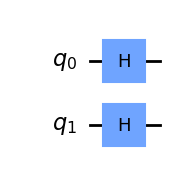

In [14]:
qc1 = QuantumCircuit(2)

qc1.h(0)
qc1.h(1)

display(qc1.draw("mpl"))

In [15]:
qc1 = QuantumCircuit(2)

qc1.h(0)
qc1.h(1)
qc1.measure_all()

backend = provider.get_backend("ibmq_qasm_simulator")
shots = 1024
qc_transpile = transpile(qc1,backend)
job = backend.run(qc_transpile, shots=shots)
job.result().get_counts()

{'00': 239, '01': 240, '10': 278, '11': 267}

Measurement 단위로 결과를 반환  
각 Measure Gate의 0/1 여부를 카운트로 세서 반환

### 2.1 Primitive - Estimator 

In [16]:
circuits = (
    qc1
)
observables = (
    SparsePauliOp("ZZ"),
)

In [17]:
backend = service.backend("ibmq_qasm_simulator")
estimator = Estimator(session=backend)

job = estimator.run(circuits, observables)

result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> EstimatorResult(values=array([-0.002]), metadata=[{'variance': 0.999996, 'shots': 4000}])
  > Expectation value: -0.002
  > Metadata: {'variance': 0.999996, 'shots': 4000}


Observable 단위로 결과를 반환  
주어진 Observable $M$과 회로 U에 대해 $\bra{0}U^{\dagger} M U \ket{0}$를 반환  
ex) 
$$\begin{align*} \bra{0}U^{\dagger}MU\ket{0} & = (\bra{00}+\bra{01}+\bra{10}+\bra{11})(Z \otimes Z)(\ket{00}+\ket{01}+\ket{10}+\ket{11}) \\ & = (\bra{00}+\bra{01}+\bra{10}+\bra{11})(\ket{00}-\ket{01}-\ket{10}+\ket{11}) \\ &= 1-1-1+1 = 0 \end{align*}$$

### 2.2 Primitive - Estimator

In [18]:
backend = service.backend("ibmq_qasm_simulator")
sampler = Sampler(session=backend)

job = sampler.run(circuits)

result = job.result()
print(f">>> {result}")
print(f"  > Quasi-distribution: {result.quasi_dists[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{1: 0.234, 3: 0.25675, 2: 0.246, 0: 0.26325}], metadata=[{'header_metadata': {}, 'shots': 4000}])
  > Quasi-distribution: {1: 0.234, 3: 0.25675, 2: 0.246, 0: 0.26325}
  > Metadata: {'header_metadata': {}, 'shots': 4000}


회로의 결과를 분포로 반환  
주어진 회로에 대해서 이항 결과물 (ex) $\ket{00},\ket{01},\ket{10},\ket{11}$)를 십진법 (ex) 0,1,2,3)으로 변환후 전체 비율을 반환해줌

In [19]:
from qiskit_ibm_runtime import Options
from qiskit_ibm_runtime import Session

# optimization_level=3 adds dynamical decoupling
# resilience_level=1 adds readout error mitigation
options = Options(optimization_level=3, resilience_level=1)

with Session(backend=backend):
    estimator = Estimator(session=backend,options=options)
    sampler = Sampler(session=backend,options = options)
    e_job = estimator.run(circuits, observables)
    s_job = sampler.run(circuits)


    e_result = e_job.result()
    s_result = s_job.result()
    print(f"-----------------------------------------------------------------------------------------")
    print(f"1. Estimator Result")
    print(f">>> {e_result}")
    print(f"  > Expectation value: {e_result.values[0]}")
    print(f"  > Metadata: {e_result.metadata[0]}")
    print(f"-----------------------------------------------------------------------------------------")
    print(f"2. Sampler Result")
    print(f">>> {s_result}")
    print(f"  > Quasi-distribution: {s_result.quasi_dists[0]}")
    print(f"  > Metadata: {s_result.metadata[0]}")
    print(f"-----------------------------------------------------------------------------------------")


-----------------------------------------------------------------------------------------
1. Estimator Result
>>> EstimatorResult(values=array([-0.0265]), metadata=[{'variance': 0.99929775, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])
  > Expectation value: -0.0265
  > Metadata: {'variance': 0.99929775, 'shots': 4000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}
-----------------------------------------------------------------------------------------
2. Sampler Result
>>> SamplerResult(quasi_dists=[{0: 0.257, 1: 0.24975, 2: 0.24525, 3: 0.248}], metadata=[{'header_metadata': {}, 'shots': 4000, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.0363544630818069}])
  > Quasi-distribution: {0: 0.257, 1: 0.24975, 2: 0.24525, 3: 0.248}
  > Metadata: {'header_metadata': {}, 'shots': 4000, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.036354463081806

Runtime에서는 Session, Option을 위와 같이 핸들링 가능

## 3. Qiskit Runtime Program 시행

### 3.1 Grover's Searching Algorithms

그로버 알고리즘은 어떤 특정한 상태만 부호를 뒤집는 오라클 함수를 대상으로 그 함수가 타깃으로 하는 아웃풋을 내놓을 확률을 증폭시키는 알고리즘이다. . 
$$ex) O_k\ket{j} = \begin{cases} -\ket{j}  & \text{if j = k}  \\ \ket{j}  & \text{otherwise} \end{cases}$$

In [20]:
import random
from qiskit.quantum_info import Statevector
from qiskit.algorithms import AmplificationProblem

secret = random.randint(0,7)  # the owner is randomly picked
secret_string = format(secret, '03b')  # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)  # let the oracle know the owner
problem = AmplificationProblem(oracle, is_good_state=secret_string)

In [21]:
from qiskit.algorithms import Grover

grover_circuits = []
for iteration in range(0,3):
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()
    grover_circuits.append(circuit)

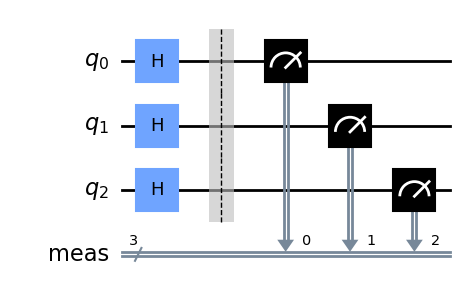

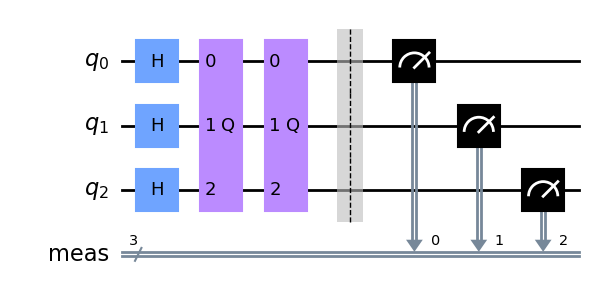

In [22]:
display(grover_circuits[0].draw("mpl"),
grover_circuits[2].draw("mpl"))

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Session

service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"  # use the simulator

In [25]:
with Session(service=service, backend=backend):
    sampler = Sampler()
    job = sampler.run(circuits=grover_circuits, shots=1000)
    result = job.result()
    print(result)

SamplerResult(quasi_dists=[{5: 0.125, 1: 0.131, 2: 0.13, 4: 0.125, 6: 0.124, 7: 0.117, 0: 0.119, 3: 0.129}, {5: 0.031, 1: 0.028, 4: 0.031, 6: 0.022, 2: 0.039, 0: 0.029, 7: 0.788, 3: 0.032}, {5: 0.008, 2: 0.008, 3: 0.006, 0: 0.006, 7: 0.944, 6: 0.01, 4: 0.005, 1: 0.013}], metadata=[{'header_metadata': {}, 'shots': 1000}, {'header_metadata': {}, 'shots': 1000}, {'header_metadata': {}, 'shots': 1000}])


As you can see, the quantum computer returned '111' as the answer with highest probability.
And the results with 2 iterations have higher probability than the results with 1 iteration.


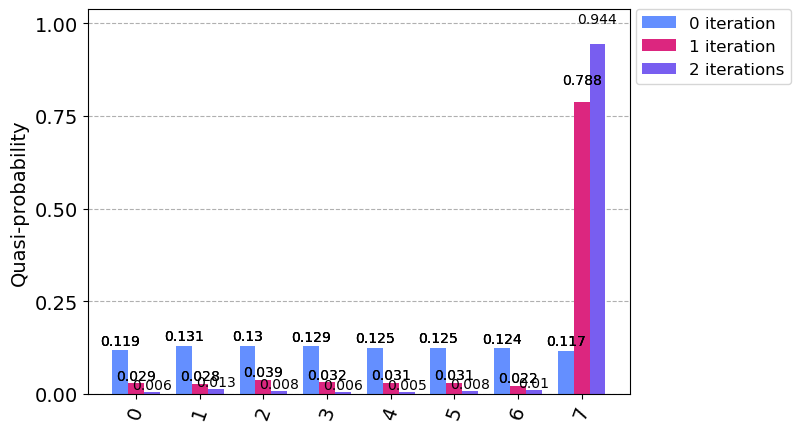

In [26]:
from qiskit.tools.visualization import plot_histogram

# Extract bit string with highest probability from results as the answer
result_dict = result.quasi_dists[1].binary_probabilities()
answer = max(result_dict, key=result_dict.get)
print(f"As you can see, the quantum computer returned '{answer}' as the answer with highest probability.\n"
       "And the results with 2 iterations have higher probability than the results with 1 iteration."
)

# Plot the results
plot_histogram(result.quasi_dists, legend=['0 iteration','1 iteration', '2 iterations'])

In [27]:
secret_string

'111'

### 3.2 QAOA
조합 최적화 문제
(프로토타입)

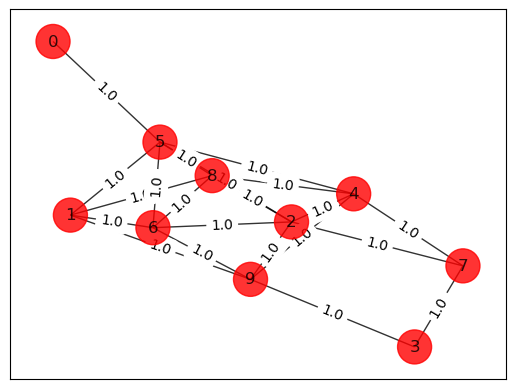

In [28]:
n=10
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))

comb_item = list(combinations(range(n), 2))
random_index = np.random.randint(1,n*(n-1)/2,3*n)
random_edge = np.array(comb_item)[random_index]

elist = [tuple(random_edge[i].tolist() + [1.0]) for i in range(3*n)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

draw_graph(G, colors, pos)

In [31]:
from qiskit.opflow import PauliSumOp

qubit_op, offset = get_operator(w)
qubit_op = PauliSumOp(qubit_op)

In [32]:
program_id = "qaoa"
qaoa_program = provider.runtime.program(program_id)

In [33]:
from qiskit_ibm_runtime import QiskitRuntimeService

options = {
	'backend_name': 'ibmq_qasm_simulator'
}

op = qubit_op
optimizer = SPSA(maxiter=100)
reps = 2
initial_point = np.random.random(2 * reps)

# The inputs of the program as described above.
runtime_inputs = {
    "operator": op,
    "reps": reps,
    "optimizer": optimizer,
    "initial_point": initial_point,
    "shots": 2**13,
    "use_swap_strategies": False,
    "use_initial_mapping": False,
    "use_pulse_efficient": False,
}

In [34]:
job = provider.runtime.run(
	program_id='qaoa',
	options=options,
	inputs=runtime_inputs
)

In [40]:
print(f"Job id: {job.job_id()}")
print(f"Job status: {job.status()}")

Job id: cfu2d0lhebj7smmtd31g
Job status: JobStatus.DONE


In [39]:
result = job.result()

In [37]:
job_id = "cfu2d0lhebj7smmtd31g"
job = service.job(job_id)
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [38]:
job.result()

{'optimizer_time': 1080.9352135658264,
 'optimal_value': -0.5450439453125004,
 'optimal_point': array([ 1.14451033,  0.27151093,  1.72596164, -0.06144993]),
 'optimal_parameters': None,
 'cost_function_evals': 200,
 'eigenstate': {'0000000000': 0.03314563036811941,
  '0000000001': 0.02209708691207961,
  '0000000010': 0.02209708691207961,
  '0000000011': 0.02209708691207961,
  '0000000100': 0.038273277230987154,
  '0000000110': 0.011048543456039806,
  '0000000111': 0.07574499777213015,
  '0000001000': 0.027063293868263706,
  '0000001001': 0.034938562148434216,
  '0000001010': 0.03314563036811941,
  '0000001011': 0.011048543456039806,
  '0000001101': 0.046875,
  '0000001110': 0.05063078670631141,
  '0000001111': 0.036643873123620545,
  '0000010001': 0.027063293868263706,
  '0000010010': 0.06346905003621844,
  '0000010100': 0.015625,
  '0000010101': 0.02209708691207961,
  '0000010110': 0.015625,
  '0000010111': 0.06442352540027595,
  '0000011000': 0.024705294220065465,
  '0000011001': 0.0